# Credit Card Approval Prediction
## Team 0123: Bradley Ge, Jim Tiao, Irene Wang, Ella Lee



### Settings. Import Libraries

In [ ]:
# data
import pandas as pd
import numpy as np

# model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from scipy.stats import pearsonr
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# viz
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")


### Part 0. Import Data

credit_df_path = 'https://drive.google.com/file/d/1ZJJ7u93uX9pDIQhOuXSI90BSmoL-IWqu/view?usp=drive_link'
app_df_path = 'https://drive.google.com/file/d/1ztJENCRUXgPVo5cWEvG3nwy6RCS3MtQo/view?usp=drive_link'

def get_gdrive_csv_link(shared_link):
    file_id = shared_link.split('/')[-2]
    return f'https://drive.google.com/uc?export=download&id={file_id}'

credit_df_path_modified = get_gdrive_csv_link(credit_df_path)
app_df_path_modified = get_gdrive_csv_link(app_df_path)

credit_df = pd.read_csv(credit_df_path_modified)
app_df = pd.read_csv(app_df_path_modified)

In [ ]:
app_df = pd.read_csv('C:/Users/bradleyGe/OneDrive - Emory University/Desktop/Emory/02_Fall/Intro to BA/00_Homework/Group Project/application_record.csv')

credit_df = pd.read_csv("C:/Users/bradleyGe/OneDrive - Emory University/Desktop/Emory/02_Fall/Intro to BA/00_Homework/Group Project/credit_record.csv")

In [ ]:
credit_df.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [ ]:
print(credit_df.shape)
print(credit_df.isna().mean())

(1048575, 3)
ID                0.0
MONTHS_BALANCE    0.0
STATUS            0.0
dtype: float64


In [ ]:
app_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


### Part 1. Data Preprocessing

#### 1-1. Sanity Check - Application Data

**Issues related to application data**
*   ***Duplicate IDs:*** The uniqueness of IDs possibly from data input error. As this can lead to duplicates when merging with the credit status data, we will remove these duplicate IDs from the application dataset.
*   ***Missing Values:*** More than 2m+ occupation type data points were missing. This might have arised from not being entered or collected. In this case we used predictive models to impute the data.



##### a) Remove Duplicate IDs

In [ ]:
# check app_df
app_df.drop_duplicates(inplace=True)

In [ ]:
## Duplicate IDs

# Get IDs with a count of 2 or more
duplicate_ids = app_df['ID'].value_counts()
duplicate_ids = duplicate_ids[duplicate_ids >= 2].index.tolist()

# Filter rows in app_df based on these IDs
filtered_rows = app_df[app_df['ID'].isin(duplicate_ids)]
filtered_rows.sort_values(by = 'ID').head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
426818,7022197,M,Y,Y,3,135000.0,Working,Secondary / secondary special,Married,House / apartment,-11945,-735,1,0,0,1,Laborers,5.0
425023,7022197,F,N,Y,0,450000.0,Commercial associate,Higher education,Separated,House / apartment,-19813,-1799,1,0,0,1,NaN,1.0
431545,7022327,F,N,Y,0,135000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-14771,-5298,1,0,0,0,High skill tech staff,1.0
431911,7022327,M,Y,Y,0,256500.0,Commercial associate,Higher education,Married,House / apartment,-21503,-1674,1,0,0,1,Core staff,2.0
425486,7023108,M,Y,Y,1,67500.0,Working,Secondary / secondary special,Married,House / apartment,-15156,-1696,1,1,0,0,Core staff,3.0


In [ ]:
# delete duplicate ids from the app_df
app_df = app_df[~app_df['ID'].isin(duplicate_ids)]

In [ ]:
# check
filtered_rows = app_df[app_df['ID'].isin(duplicate_ids)]
filtered_rows.sort_values(by = 'ID').head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS


##### b) Missing Values Imputation

In [ ]:
## Missing Values
print(app_df.isna().mean())
print('number of missing values - occupation type:', app_df['OCCUPATION_TYPE'].isna().sum())

ID                     0.000000
CODE_GENDER            0.000000
FLAG_OWN_CAR           0.000000
FLAG_OWN_REALTY        0.000000
CNT_CHILDREN           0.000000
AMT_INCOME_TOTAL       0.000000
NAME_INCOME_TYPE       0.000000
NAME_EDUCATION_TYPE    0.000000
NAME_FAMILY_STATUS     0.000000
NAME_HOUSING_TYPE      0.000000
DAYS_BIRTH             0.000000
DAYS_EMPLOYED          0.000000
FLAG_MOBIL             0.000000
FLAG_WORK_PHONE        0.000000
FLAG_PHONE             0.000000
FLAG_EMAIL             0.000000
OCCUPATION_TYPE        0.306017
CNT_FAM_MEMBERS        0.000000
dtype: float64
number of missing values - occupation type: 134177


In [ ]:
# Use predictive imputations to fill occupation type missing values

# Split data into sets with missing and non-missing target values
train_data = app_df[app_df['OCCUPATION_TYPE'].notna()]
test_data = app_df[app_df['OCCUPATION_TYPE'].isna()]

# Define predictors (X) and the target (y)
X_train = train_data.drop(columns=['OCCUPATION_TYPE'])
y_train = train_data['OCCUPATION_TYPE']
X_test = test_data.drop(columns=['OCCUPATION_TYPE'])

# into numerical features
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Initialize the model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Predict the missing values
predicted_values = model.predict(X_test)

# Fill the original dataframe with the imputed values
app_df.loc[app_df['OCCUPATION_TYPE'].isna(), 'OCCUPATION_TYPE'] = predicted_values

In [ ]:
print('number of missing values - occupation type:', app_df['OCCUPATION_TYPE'].isna().sum())
app_df['OCCUPATION_TYPE'].value_counts()

number of missing values - occupation type: 0


Laborers                 125306
Core staff                64432
Sales staff               58236
Managers                  45954
Drivers                   32220
Cleaning staff            24584
Accountants               19541
High skill tech staff     19121
Medicine staff            16227
Security staff            10621
Cooking staff              9966
Private service staff      3672
Secretaries                2190
Low-skill Laborers         2180
Waiters/barmen staff       1726
Realty agents              1073
HR staff                    804
IT staff                    610
Name: OCCUPATION_TYPE, dtype: int64

#### 1-2. Target Variable Inspection - Credit Data

In [ ]:
credit_df['STATUS'].value_counts()
credit_df['STATUS'].isna().sum()

0

In [ ]:
# refactor target variable column
# maps 'C' to 0 (repay on time), 1-5 to 1, X remains same
credit_df['STATUS_RE'] = credit_df['STATUS'].map({'C':0, '0':1, '1':1, '2':1, '3':1, '4':1, '5':1, 'X':'X'})
credit_df['STATUS_RE'].value_counts()

0    442031
1    397314
X    209230
Name: STATUS_RE, dtype: int64

In [ ]:
# exclude X
credit_df = credit_df[credit_df['STATUS_RE'] != 'X']
credit_df['STATUS_RE'].value_counts()

0    442031
1    397314
Name: STATUS_RE, dtype: int64

In [ ]:
credit_df['STATUS_RE'].isna().sum()

0

In [ ]:
# exclude X
credit_df = credit_df[credit_df['STATUS_RE'] != 'X']

# aggregate values by customer id on #of failures & #of months
agg_df = credit_df.groupby('ID').agg(
    total_status_re=('STATUS_RE', 'sum'),
    total_month_count=('MONTHS_BALANCE', 'count')
).reset_index()
agg_df

,ID,total_status_re,total_month_count
0,5001711,3,3
1,5001712,10,19
2,5001717,17,22
3,5001718,26,29
4,5001719,2,43
...,...,...,...
41444,5150480,6,26
41445,5150482,12,18
41446,5150484,12,13
41447,5150485,2,2


In [ ]:
# calculate percentage
agg_df['percentage'] = agg_df['total_status_re']/agg_df['total_month_count']
agg_df.columns = agg_df.columns.str.upper()
agg_df.head()

,ID,TOTAL_STATUS_RE,TOTAL_MONTH_COUNT,PERCENTAGE
0,5001711,3,3,1.0
1,5001712,10,19,0.526316
2,5001717,17,22,0.772727
3,5001718,26,29,0.896552
4,5001719,2,43,0.046512


In [ ]:
# function that generates binary values by different thresholds

def generate_binary_output(dataframe, threshold, col_name):
    dataframe[col_name] = (dataframe['PERCENTAGE'] >= threshold).astype(int)
    return dataframe

Threshold: 0.05%
            ID PERCENTAGE  binary_0.05
0      5001711        1.0            1
1      5001712   0.526316            1
2      5001717   0.772727            1
3      5001718   0.896552            1
4      5001719   0.046512            0
...        ...        ...          ...
41444  5150480   0.230769            1
41445  5150482   0.666667            1
41446  5150484   0.923077            1
41447  5150485        1.0            1
41448  5150487        0.0            0

[41449 rows x 3 columns]


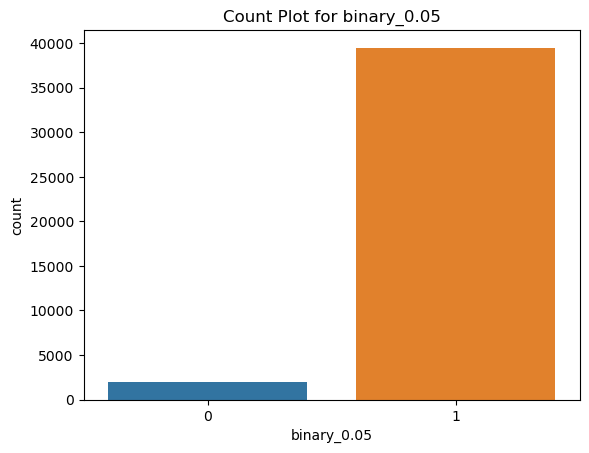



Threshold: 0.1%
            ID PERCENTAGE  binary_0.10
0      5001711        1.0            1
1      5001712   0.526316            1
2      5001717   0.772727            1
3      5001718   0.896552            1
4      5001719   0.046512            0
...        ...        ...          ...
41444  5150480   0.230769            1
41445  5150482   0.666667            1
41446  5150484   0.923077            1
41447  5150485        1.0            1
41448  5150487        0.0            0

[41449 rows x 3 columns]


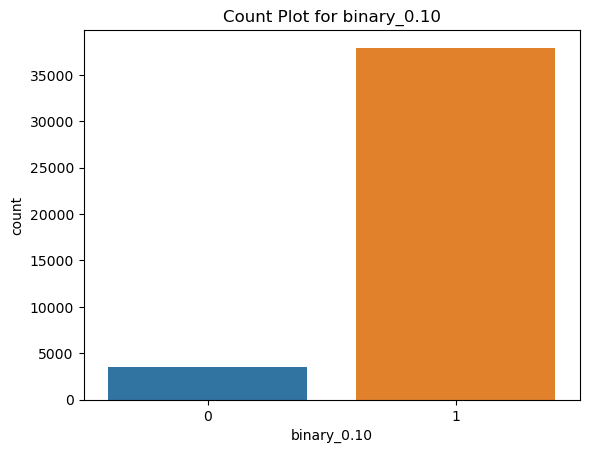



Threshold: 0.15000000000000002%
            ID PERCENTAGE  binary_0.15
0      5001711        1.0            1
1      5001712   0.526316            1
2      5001717   0.772727            1
3      5001718   0.896552            1
4      5001719   0.046512            0
...        ...        ...          ...
41444  5150480   0.230769            1
41445  5150482   0.666667            1
41446  5150484   0.923077            1
41447  5150485        1.0            1
41448  5150487        0.0            0

[41449 rows x 3 columns]


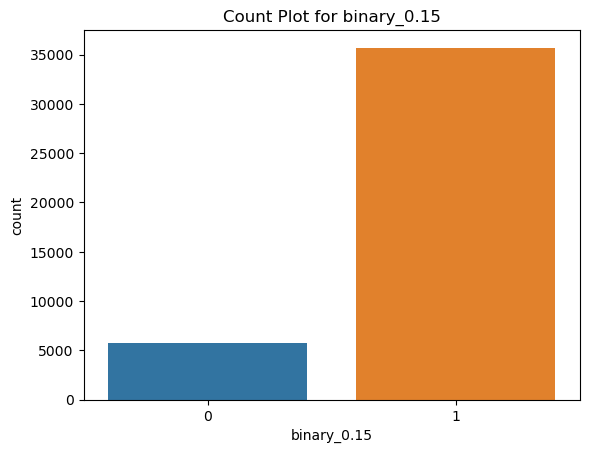



Threshold: 0.2%
            ID PERCENTAGE  binary_0.20
0      5001711        1.0            1
1      5001712   0.526316            1
2      5001717   0.772727            1
3      5001718   0.896552            1
4      5001719   0.046512            0
...        ...        ...          ...
41444  5150480   0.230769            1
41445  5150482   0.666667            1
41446  5150484   0.923077            1
41447  5150485        1.0            1
41448  5150487        0.0            0

[41449 rows x 3 columns]


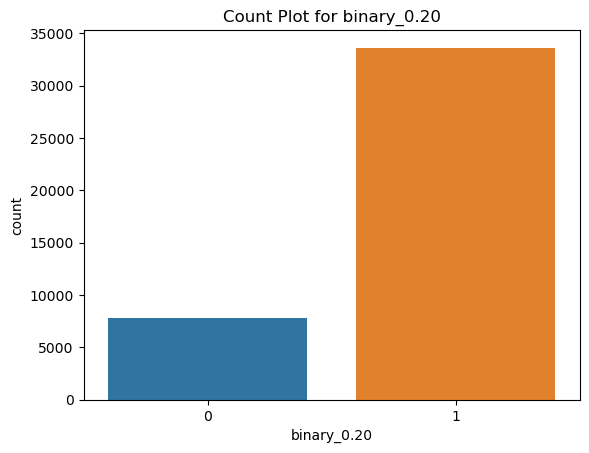



Threshold: 0.25%
            ID PERCENTAGE  binary_0.25
0      5001711        1.0            1
1      5001712   0.526316            1
2      5001717   0.772727            1
3      5001718   0.896552            1
4      5001719   0.046512            0
...        ...        ...          ...
41444  5150480   0.230769            0
41445  5150482   0.666667            1
41446  5150484   0.923077            1
41447  5150485        1.0            1
41448  5150487        0.0            0

[41449 rows x 3 columns]


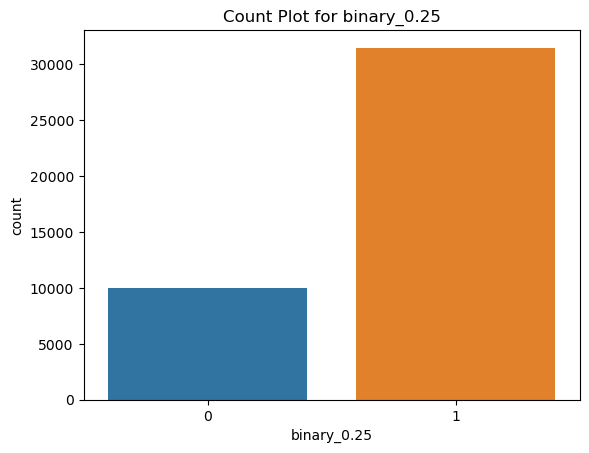



Threshold: 0.3%
            ID PERCENTAGE  binary_0.30
0      5001711        1.0            1
1      5001712   0.526316            1
2      5001717   0.772727            1
3      5001718   0.896552            1
4      5001719   0.046512            0
...        ...        ...          ...
41444  5150480   0.230769            0
41445  5150482   0.666667            1
41446  5150484   0.923077            1
41447  5150485        1.0            1
41448  5150487        0.0            0

[41449 rows x 3 columns]


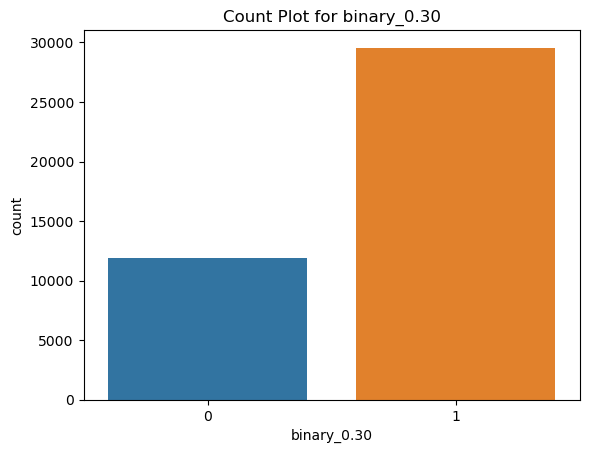



Threshold: 0.35000000000000003%
            ID PERCENTAGE  binary_0.35
0      5001711        1.0            1
1      5001712   0.526316            1
2      5001717   0.772727            1
3      5001718   0.896552            1
4      5001719   0.046512            0
...        ...        ...          ...
41444  5150480   0.230769            0
41445  5150482   0.666667            1
41446  5150484   0.923077            1
41447  5150485        1.0            1
41448  5150487        0.0            0

[41449 rows x 3 columns]


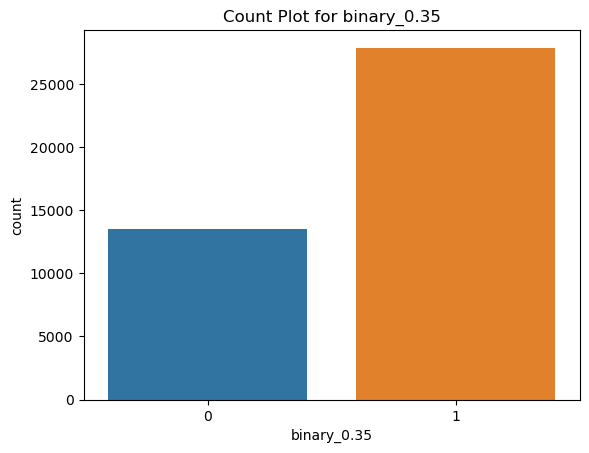



Threshold: 0.4%
            ID PERCENTAGE  binary_0.40
0      5001711        1.0            1
1      5001712   0.526316            1
2      5001717   0.772727            1
3      5001718   0.896552            1
4      5001719   0.046512            0
...        ...        ...          ...
41444  5150480   0.230769            0
41445  5150482   0.666667            1
41446  5150484   0.923077            1
41447  5150485        1.0            1
41448  5150487        0.0            0

[41449 rows x 3 columns]


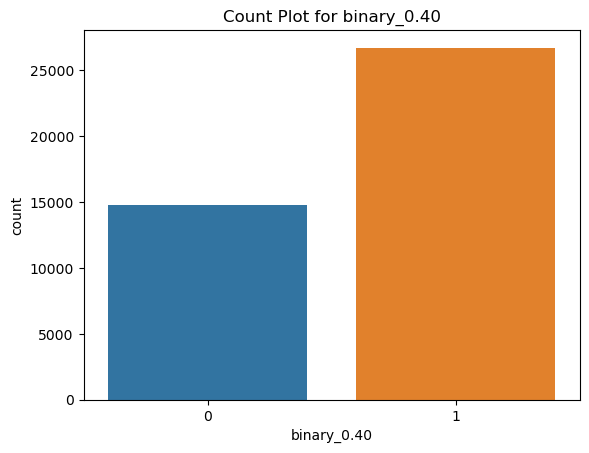



Threshold: 0.45%
            ID PERCENTAGE  binary_0.45
0      5001711        1.0            1
1      5001712   0.526316            1
2      5001717   0.772727            1
3      5001718   0.896552            1
4      5001719   0.046512            0
...        ...        ...          ...
41444  5150480   0.230769            0
41445  5150482   0.666667            1
41446  5150484   0.923077            1
41447  5150485        1.0            1
41448  5150487        0.0            0

[41449 rows x 3 columns]


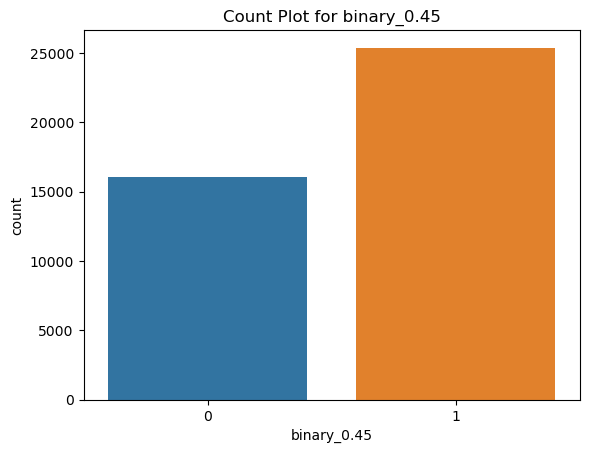



Threshold: 0.5%
            ID PERCENTAGE  binary_0.50
0      5001711        1.0            1
1      5001712   0.526316            1
2      5001717   0.772727            1
3      5001718   0.896552            1
4      5001719   0.046512            0
...        ...        ...          ...
41444  5150480   0.230769            0
41445  5150482   0.666667            1
41446  5150484   0.923077            1
41447  5150485        1.0            1
41448  5150487        0.0            0

[41449 rows x 3 columns]


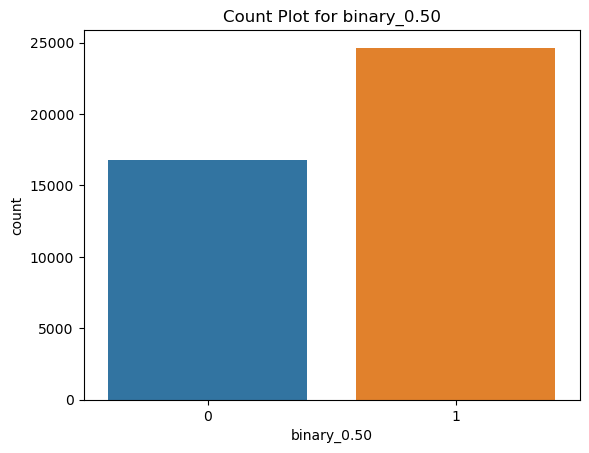

In [ ]:
# check distribution for different thresholds

threshold_values = np.arange(0.05, 0.55, 0.05)

for threshold_value in threshold_values:
    col_name = f'binary_{threshold_value:.2f}'
    result_with_binary_output = generate_binary_output(agg_df.copy(), threshold_value, col_name)

    # Reset the index to make 'ID' a column instead of an index
    result_with_binary_output = result_with_binary_output.reset_index()

    # Display the result with the binary output
    print(f"Threshold: {threshold_value}%")
    print(result_with_binary_output[['ID', 'PERCENTAGE', col_name]])
    sns.countplot(x=col_name, data=result_with_binary_output)
    plt.title(f'Count Plot for {col_name}')
    plt.show()
    print("\n")

In [ ]:
# final target feature
agg_df['STATUS_M'] = np.where(agg_df['PERCENTAGE'] > 0.05, 1, 0)
agg_df

,ID,TOTAL_STATUS_RE,TOTAL_MONTH_COUNT,PERCENTAGE,STATUS_M
0,5001711,3,3,1.0,1
1,5001712,10,19,0.526316,1
2,5001717,17,22,0.772727,1
3,5001718,26,29,0.896552,1
4,5001719,2,43,0.046512,0
...,...,...,...,...,...
41444,5150480,6,26,0.230769,1
41445,5150482,12,18,0.666667,1
41446,5150484,12,13,0.923077,1
41447,5150485,2,2,1.0,1


#### 1-3. Merge Data & Customer-level aggregation

In [ ]:
merged_df = agg_df[['ID', 'STATUS_M', 'TOTAL_MONTH_COUNT']].merge(app_df, on = 'ID', how ='inner')

In [ ]:
df = merged_df.copy()

#### 1-4. One-hot encoding

In [ ]:
# Find non-binary categorical columns
non_binary_cols = df.select_dtypes(['object', 'category']).nunique()[lambda x: x > 2].index.tolist()

# One-hot encode only the non-binary columns
df = pd.get_dummies(df, columns=non_binary_cols)

In [ ]:
df.head()

,ID,STATUS_M,TOTAL_MONTH_COUNT,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,...,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff
0,5008804,1,15,M,Y,Y,0,427500.0,-12005,-4542,...,0,0,1,0,0,0,0,0,0,0
1,5008805,1,14,M,Y,Y,0,427500.0,-12005,-4542,...,0,0,1,0,0,0,0,0,0,0
2,5008806,1,14,M,Y,Y,0,112500.0,-21474,-1134,...,0,0,0,0,0,0,0,0,1,0
3,5008808,1,2,F,N,Y,0,270000.0,-19110,-3051,...,0,0,0,0,0,0,1,0,0,0
4,5008810,1,21,F,N,Y,0,270000.0,-19110,-3051,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
# Assuming your DataFrame is named 'df'
# Use the info() method to get information about all columns, including their data types
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 33110 entries, 0 to 33109
Data columns (total 54 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   ID                                                 33110 non-null  int64  
 1   STATUS_M                                           33110 non-null  int32  
 2   TOTAL_MONTH_COUNT                                  33110 non-null  int64  
 3   CODE_GENDER                                        33110 non-null  object 
 4   FLAG_OWN_CAR                                       33110 non-null  object 
 5   FLAG_OWN_REALTY                                    33110 non-null  object 
 6   CNT_CHILDREN                                       33110 non-null  int64  
 7   AMT_INCOME_TOTAL                                   33110 non-null  float64
 8   DAYS_BIRTH                                         33110 non-null  int64  
 9   DAYS_E

In [ ]:
df.columns = df.columns.str.lower()
df.columns

Index(['id', 'status_m', 'total_month_count', 'code_gender', 'flag_own_car',
       'flag_own_realty', 'cnt_children', 'amt_income_total', 'days_birth',
       'days_employed', 'flag_mobil', 'flag_work_phone', 'flag_phone',
       'flag_email', 'cnt_fam_members',
       'name_income_type_commercial associate', 'name_income_type_pensioner',
       'name_income_type_state servant', 'name_income_type_student',
       'name_income_type_working', 'name_education_type_academic degree',
       'name_education_type_higher education',
       'name_education_type_incomplete higher',
       'name_education_type_lower secondary',
       'name_education_type_secondary / secondary special',
       'name_family_status_civil marriage', 'name_family_status_married',
       'name_family_status_separated',
       'name_family_status_single / not married', 'name_family_status_widow',
       'name_housing_type_co-op apartment',
       'name_housing_type_house / apartment',
       'name_housing_type_municip

In [ ]:
# Select categorical columns
categorical_columns = ['code_gender', 'flag_own_car', 'flag_own_realty']
#print(categorical_columns)
## CODE_GENDER	FLAG_OWN_CAR	FLAG_OWN_REALTY
# Replace categorical values with numeric codes (0 and 1)
for col in categorical_columns:
    df[col] = pd.factorize(df[col])[0]

df.head()

,id,status_m,total_month_count,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,days_birth,days_employed,...,occupation_type_laborers,occupation_type_low-skill laborers,occupation_type_managers,occupation_type_medicine staff,occupation_type_private service staff,occupation_type_realty agents,occupation_type_sales staff,occupation_type_secretaries,occupation_type_security staff,occupation_type_waiters/barmen staff
0,5008804,1,15,0,0,0,0,427500.0,-12005,-4542,...,0,0,1,0,0,0,0,0,0,0
1,5008805,1,14,0,0,0,0,427500.0,-12005,-4542,...,0,0,1,0,0,0,0,0,0,0
2,5008806,1,14,0,0,0,0,112500.0,-21474,-1134,...,0,0,0,0,0,0,0,0,1,0
3,5008808,1,2,1,1,0,0,270000.0,-19110,-3051,...,0,0,0,0,0,0,1,0,0,0
4,5008810,1,21,1,1,0,0,270000.0,-19110,-3051,...,0,0,0,0,0,0,1,0,0,0


### Part 2. Exploratory Analysis

#### 2-1. Customer features & Feature Engineering

In [ ]:
# number of users in the merged dataset
print('Number of users:', df['id'].nunique())

# average number of children
print('Average number of children:', df['cnt_children'].mean())

# average income
print('Average Income:', df['amt_income_total'].mean())

# average days employed
print('Average days employed:', df['days_employed'].mean())

# distribution of occupation type
print('Number of users:', df['id'].nunique())

Number of users: 33110
Average number of children: 0.4277559649652673
Average Income: 185877.1707037149
Average days employed: 60031.02908486862
Number of users: 33110


In [ ]:
# Transform days_employed column
# employed binary
df['employed'] = df['days_employed'] < 0
df['employed']

# change days_employed for interpreation (0 to n)
df['days_employed'] =  np.where(df['days_employed'] > 0, 0, -df['days_employed'])

In [ ]:
# change days_birth for interpretation (0 to n)
df['days_birth'] =  -df['days_birth']

#### 2-2. Credit Status of Customers

<Axes: >

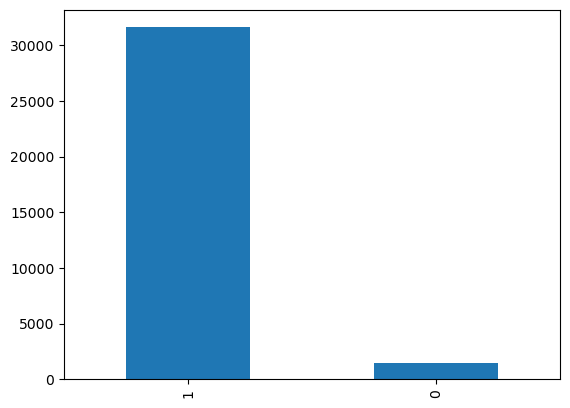

In [ ]:
df['status_m'].value_counts().plot(kind='bar')

#### 2-3. Features related to Credit Status

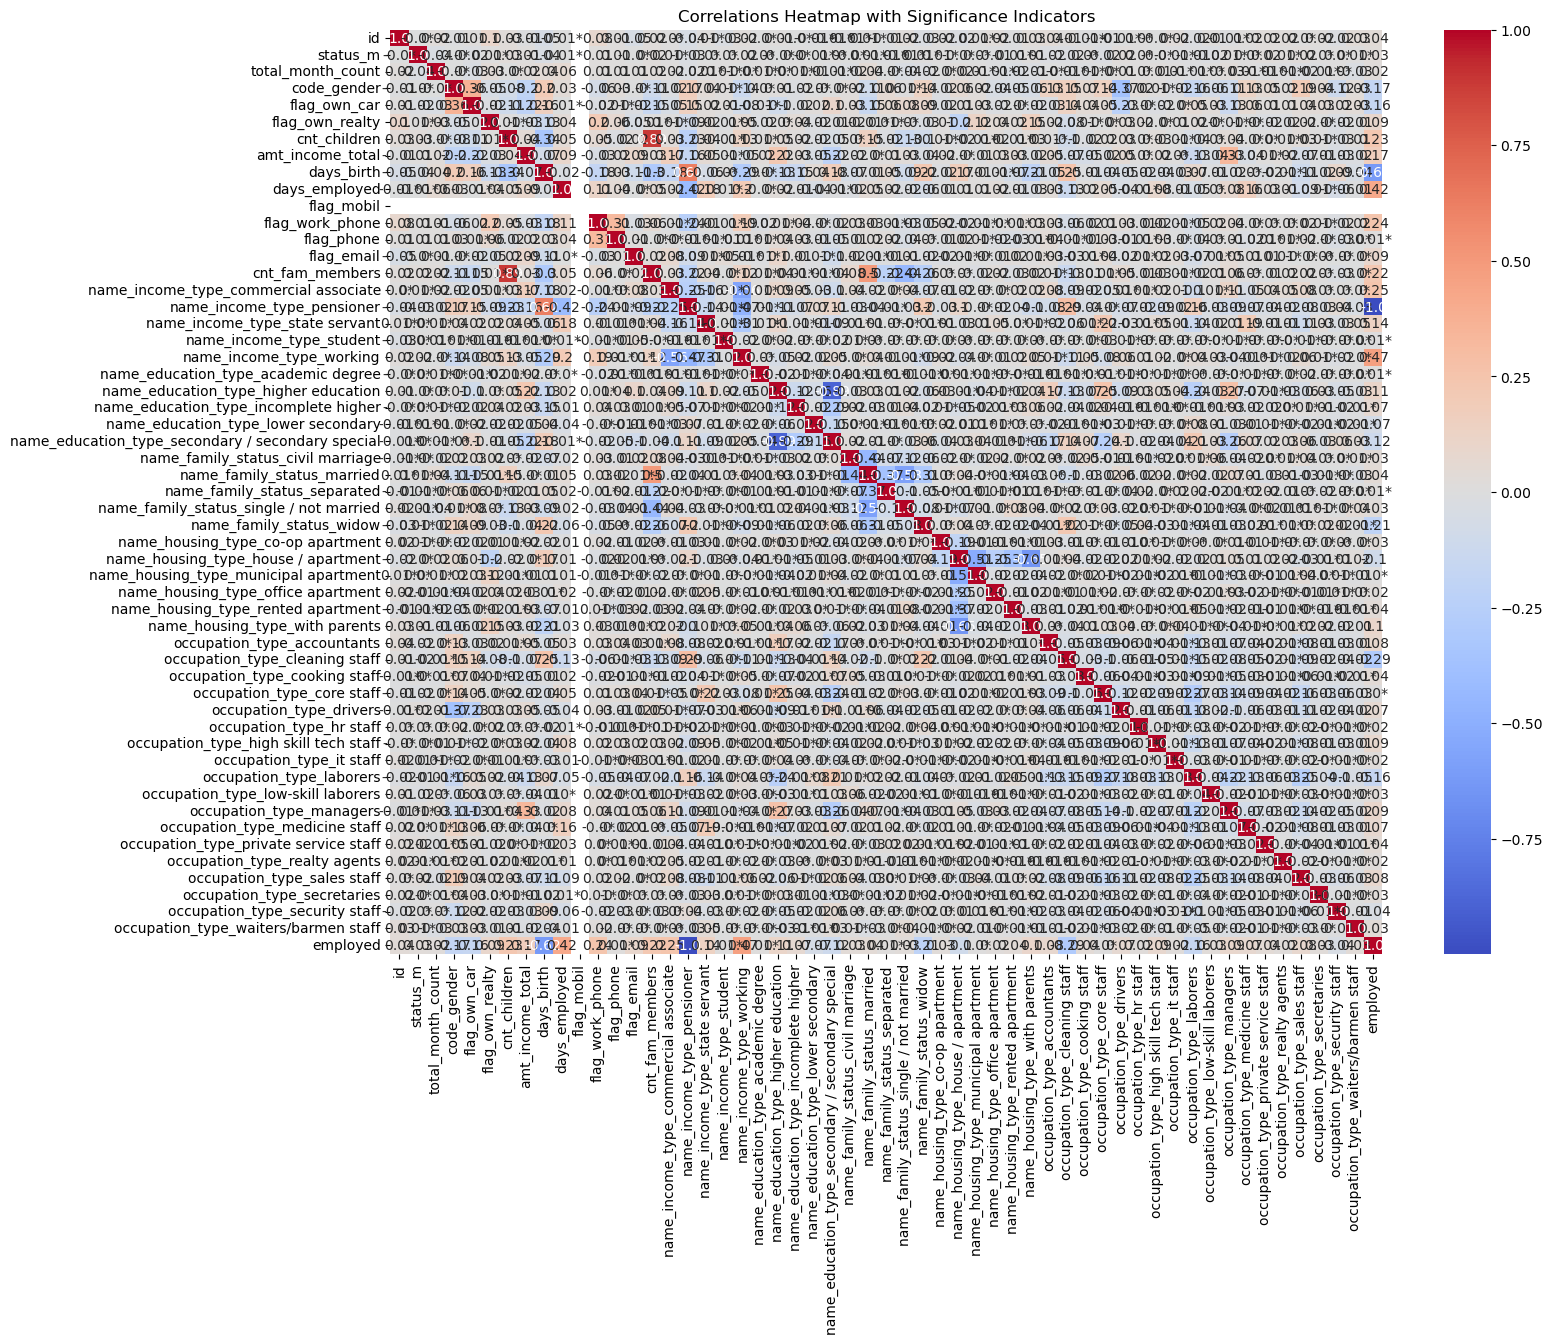

In [ ]:
# Correlation matrix
corr = df.corr()

# Compute the p-value matrix
p_val = np.zeros(corr.shape)
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        _, p = pearsonr(df.iloc[:, i], df.iloc[:, j])
        p_val[i, j] = p

# Create annotations: asterisk for non-significant correlations, value for significant ones
annotations = np.where(p_val > 0.05,
                      np.char.add(np.round(corr.values, 2).astype(str), '*'),
                      np.round(corr.values, 2).astype(str))
plt.figure(figsize=(16, 12))
sns.heatmap(corr, annot=annotations, cmap='coolwarm', fmt='s')
plt.title("Correlations Heatmap with Significance Indicators")
plt.show()

### Part 3. Dealing with Imbalanced Data

#### 3-1. Oversampling

##### a) Train-test split and oversampling

In [ ]:
y = df['status_m']
X = df.drop(columns = ['status_m'])

In [ ]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Instantiate the random over sampler
ros = RandomOverSampler(random_state=42)

# Use the random over sampler to oversample the training set
X_train_oversampled, y_train_oversampled = ros.fit_resample(X_train, y_train)

# Print the number of samples per class to verify oversampling
print('Resampled dataset shape %s' % Counter(y_train_oversampled))

Resampled dataset shape Counter({1: 22101, 0: 22101})


##### b) Classification Model Train & Hyperparameter Tuning

In [ ]:
def perform_grid_search(model, params, X_train, y_train, scoring='accuracy', cv=10):
    """
    Perform Grid Search for the given model and parameters.

    Parameters:
    - model: Initialized classifier (e.g., DecisionTreeClassifier(), LogisticRegression(), etc.)
    - params: Parameter grid for GridSearchCV
    - X_train: Training data features
    - y_train: Training data target variable
    - scoring: Scoring metric (default is 'accuracy')
    - cv: Number of cross-validation folds (default is 5)

    Returns:
    - best_estimator: Trained model with best parameters from grid search
    """

    grid_search = GridSearchCV(estimator=model, param_grid=params, scoring=scoring, cv=cv)
    grid_search.fit(X_train, y_train)

    print(f"Best parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    print(f"Best {scoring} score: {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_

In [ ]:
# Decision Tree
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_params = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [ ]:
best_dt = perform_grid_search(dt_classifier, dt_params, X_train_oversampled, y_train_oversampled)

Best parameters for DecisionTreeClassifier: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best accuracy score: 0.9807


In [ ]:


# Logistic Regression
lr_classifier = LogisticRegression(random_state=42, max_iter=10000)
lr_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}
best_lr = perform_grid_search(lr_classifier, lr_params, X_train_oversampled, y_train_oversampled)



Best parameters for LogisticRegression: {'C': 1, 'solver': 'newton-cg'}
Best accuracy score: 0.5793


In [ ]:
lr_classifier = LogisticRegression(random_state=42, max_iter=10000)
lr_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}


In [ ]:

from sklearn.neighbors import KNeighborsClassifier
# K-Nearest Neighbors
knn_classifier = KNeighborsClassifier()
knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
best_knn = perform_grid_search(knn_classifier, knn_params, X_train_oversampled, y_train_oversampled)

Best parameters for KNeighborsClassifier: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best accuracy score: 0.9753


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# K-Nearest Neighbors
knn_classifier = KNeighborsClassifier()
knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}


##### c) Model Performance

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model_performance(model, X_test, y_test):
    """
    Evaluate and print performance metrics of a given model on the test set.

    Parameters:
    - model: Trained classifier
    - X_test: Test data features
    - y_test: Test data target variable
    """
    y_pred = model.predict(X_test)

    print(f"Model: {model.__class__.__name__}")
    print("--------------------------")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\n")

# Evaluate performance for each best model
evaluate_model_performance(best_dt, X_test, y_test)
evaluate_model_performance(best_lr, X_test, y_test)
evaluate_model_performance(best_knn, X_test, y_test)

#### 3-2. Undersampling

In [ ]:
# Instantiate the random under sampler
rus = RandomUnderSampler(random_state=42)

# Use the random over sampler to oversample the training set
X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train, y_train)

# Print the number of samples per class to verify oversampling
print('Resampled dataset shape %s' % Counter(y_train_undersampled))

Resampled dataset shape Counter({0: 1076, 1: 1076})


In [ ]:
# Decision Tree
best_dt_us = perform_grid_search(dt_classifier, dt_params, X_train_undersampled, y_train_undersampled)


Best parameters for DecisionTreeClassifier: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best accuracy score: 0.6031


In [ ]:
# Logistic Regression
best_lr_us = perform_grid_search(lr_classifier, lr_params, X_train_undersampled, y_train_undersampled)

Best parameters for LogisticRegression: {'C': 0.01, 'solver': 'newton-cg'}
Best accuracy score: 0.5646


In [ ]:
# K-Nearest Neighbors
best_knn_us = perform_grid_search(knn_classifier, knn_params, X_train_undersampled, y_train_undersampled)

Best parameters for KNeighborsClassifier: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Best accuracy score: 0.6408


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model_performance(model, X_test, y_test):
    """
    Evaluate and print performance metrics of a given model on the test set.

    Parameters:
    - model: Trained classifier
    - X_test: Test data features
    - y_test: Test data target variable
    """
    y_pred = model.predict(X_test)

    print(f"Model: {model.__class__.__name__}")
    print("--------------------------")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\n")
# Evaluate performance for each best model
evaluate_model_performance(best_dt_us, X_test, y_test)
evaluate_model_performance(best_lr_us, X_test, y_test)
evaluate_model_performance(best_knn_us, X_test, y_test)

Model: DecisionTreeClassifier
--------------------------
Accuracy: 0.5364
Precision: 0.9720
Recall: 0.5303
F1 Score: 0.6862
Confusion Matrix:
[[ 293  145]
 [4460 5035]]


Model: LogisticRegression
--------------------------
Accuracy: 0.5564
Precision: 0.9646
Recall: 0.5564
F1 Score: 0.7057
Confusion Matrix:
[[ 244  194]
 [4212 5283]]


Model: KNeighborsClassifier
--------------------------
Accuracy: 0.5955
Precision: 0.9747
Recall: 0.5922
F1 Score: 0.7368
Confusion Matrix:
[[ 292  146]
 [3872 5623]]




#### 3-3. SMOTE

In [ ]:
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

In [ ]:
# Decision Tree
best_dt_us = perform_grid_search(dt_classifier, dt_params, X_train_smote, y_train_smote)



Best parameters for DecisionTreeClassifier: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best accuracy score: 0.9587


In [ ]:
# Logistic Regression
best_lr_us = perform_grid_search(lr_classifier, lr_params, X_train_smote, y_train_smote)



Best parameters for LogisticRegression: {'C': 100, 'solver': 'newton-cg'}
Best accuracy score: 0.8538


In [ ]:
# K-Nearest Neighbors
best_knn_us = perform_grid_search(knn_classifier, knn_params, X_train_smote, y_train_smote)

Best parameters for KNeighborsClassifier: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best accuracy score: 0.9467
